# JUST RUN THIS SECTION FOR FIRST TIME

In [1]:
formulae_train = open("Dataset/formulas/train_formulas.txt",'r').readlines()
formulae_valid = open("Dataset/formulas/validation_formulas.txt",'r').readlines()

formulae = formulae_train + formulae_valid

set_list = set()
for i in range(len(formulae)):
    form = formulae[i].strip().split()
    set_list = set_list.union(set(form))
    
set_list = list(set_list)
fname = 'vocab'
f = open(fname, 'w')
for i in range(len(set_list)):
    if i == len(set_list)-1 :
        exp = set_list[i]
        f.write(exp)
    else:
        exp = set_list[i]+'\n'
        f.write(exp)
f.close()

In [1]:
from glob import glob
import numpy as np
from IPython.display import display, Math, Latex, Image
import subprocess, sys, shlex
import os
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
import random
import os
import matplotlib.pyplot as plt


# four meta keywords
# 0: START
# 1: END
# 2: UNKNOWN

def load_data():
    
    
    vocab = open('vocab').read().split('\n')
    vocab_to_idx = dict([ (vocab[i],i) for i in range(len(vocab))])

    formulae_train = open("Dataset/formulas/train_formulas.txt",'r').read().split('\n')
    formulae_valid = open("Dataset/formulas/validation_formulas.txt",'r').read().split('\n')
    # formulae_test = open("Dataset/formulas/test_formulas.txt",'r').read().split('\n')
    
    def formula_to_indices(formula):
        formula = formula.split(' ')
        res = [0]
        for token in formula:
            if token in vocab_to_idx:
                res.append( vocab_to_idx[token] + 3 )
            else:
                res.append(2)
        res.append(1)
        return res

    formulae_train = list(map( formula_to_indices, formulae_train))
    formulae_valid = list(map( formula_to_indices, formulae_valid))
    # formulae_test = list(map( formula_to_indices, formulae_test))

    def import_images_train(datum):
        img = np.array(Image.open(datum).convert('L'))
        return (img, formulae_train[ int(datum.split('/')[3].split('.')[0]) ])

    def import_images_valid(datum):
        img = np.array(Image.open(datum).convert('L'))
        return (img, formulae_valid[ int(datum.split('/')[3].split('.')[0]) ])
    
#     def import_images_test(datum):
#         img = np.array(Image.open(datum).convert('L'))
#         return img

    train = glob("Dataset/images/images_train/*.png")
    val = glob("Dataset/images/images_validation/*.png")
    # test = glob("Dataset/images/images_test/*.png")
    
    train = map(import_images_train, train)
    val = map(import_images_valid, val)
    # test = map(import_images_test, test)


    return train, val, # test

In [2]:
vocab = open('vocab').read().split('\n')
vocab_to_idx = dict([ (vocab[i],i) for i in range(len(vocab))])
idx_to_vocab = {y:x for x,y in vocab_to_idx.items()}

In [29]:
vocab_to_idx

{'~': 0,
 '\\_': 1,
 '\\pmatrix': 2,
 '\\mathsf': 3,
 '\\large': 4,
 '\\rlap': 5,
 's': 6,
 '\\do': 7,
 '\\it': 8,
 ',': 9,
 '\\i': 10,
 '\\rightarrowfill': 11,
 '\\zeta': 12,
 '\\nu': 13,
 '\\varsigma': 14,
 'C': 15,
 'X': 16,
 '\\rule': 17,
 '\\mathstrut': 18,
 '*': 19,
 '\\ae': 20,
 '\\tan': 21,
 '\\bigtriangleup': 22,
 '\\exp': 23,
 '\\!': 24,
 '>': 25,
 '\\iota': 26,
 '\\Bigr': 27,
 '3': 28,
 '\\Big': 29,
 '\\scriptscriptstyle': 30,
 '\\hfil': 31,
 '\\vrule': 32,
 '\\equiv': 33,
 '\\rbrack': 34,
 '\\widetilde': 35,
 '\\infty': 36,
 '\\thinspace': 37,
 '4': 38,
 '\\pm': 39,
 '\\subset': 40,
 '2mm': 41,
 '(': 42,
 '\\sqrt': 43,
 '\\Xi': 44,
 'h': 45,
 '\\textit': 46,
 '\\Bigg': 47,
 'v': 48,
 '\\mkern': 49,
 '\\vskip': 50,
 '7pt': 51,
 '8pt': 52,
 ':': 53,
 '\\big': 54,
 '\\Theta': 55,
 '\\P': 56,
 '{picture}': 57,
 '\\oint': 58,
 '\\mp': 59,
 '\\downarrow': 60,
 '\\slash': 61,
 '\\S': 62,
 '\\Phi': 63,
 '\\LARGE': 64,
 '\\hphantom': 65,
 '\\hbar': 66,
 '\\line': 67,
 '\\overline': 

In [17]:
dict_length = 569
input_embedding_size = 80
batch_size = 1
enc_lstm_dim = 256
vocab_size = 569
epochs = 20
lr_base = 2e-2
lr_decay = 0.98

# ENCODER IMPLEMENTATION WITH LEARNABLE INITIAL STATES

In [4]:
def fn(inp):
    batch_size = 1
    enc_lstm_dim = 256
    enc_init_shape = [batch_size, enc_lstm_dim]
    with tf.variable_scope('encoder_rnn'):
        
        with tf.variable_scope('forward'):
            
            cell_encoder_forward = tf.contrib.rnn.LSTMCell(num_units = enc_lstm_dim, 
                                                           use_peepholes = True, 
                                                           initializer = tf.contrib.layers.xavier_initializer(),
                                                           activation = 'tanh',
                                                           name = 'cell_encoder_forward')
            init_fw = tf.nn.rnn_cell.LSTMStateTuple(
                      tf.get_variable("enc_fw_c", enc_init_shape),
                      tf.get_variable("enc_fw_h", enc_init_shape)
                      )
        with tf.variable_scope('backward'):
            
            cell_encoder_backward = tf.contrib.rnn.LSTMCell(num_units = enc_lstm_dim, 
                                                            use_peepholes = True, 
                                                            initializer = tf.contrib.layers.xavier_initializer(),
                                                            activation = 'tanh',
                                                            name = 'cell_encoder_backward')
            
            init_bw = tf.nn.rnn_cell.LSTMStateTuple(
                      tf.get_variable("enc_bw_c", enc_init_shape),
                      tf.get_variable("enc_bw_h", enc_init_shape)
                      )
        output, _ = tf.nn.bidirectional_dynamic_rnn(cell_encoder_forward, 
                                                    cell_encoder_backward, 
                                                    inp, 
                                                    sequence_length = tf.fill([batch_size],
                                                                              tf.shape(inp)[1]),
                                                    dtype=tf.float32,
                                                    initial_state_fw = init_fw,
                                                    initial_state_bw = init_bw
                                                    
                                                    )
        output  = tf.concat([output[0],output[1]],axis=-1)
        # tf.concat(2,output)
        return output

# NETWORK STRUCTURE

In [6]:
tf.reset_default_graph()

Input = tf.placeholder(tf.float32, [batch_size, 60,400,1])

CONV1 = tf.layers.conv2d(Input, 64, 3, 1,'SAME', activation = tf.nn.relu)

print(CONV1.shape)

CONV1 = tf.layers.max_pooling2d(CONV1, 2, 2,'SAME')

print(CONV1.shape)

CONV2 = tf.layers.conv2d(CONV1, 128, 3, 1,'SAME', activation = tf.nn.relu)

print(CONV2.shape)

CONV2 = tf.layers.max_pooling2d(CONV2, 2, 2,'SAME')

print(CONV2.shape)

CONV3 = tf.layers.conv2d(CONV2, 256, 3, 1, 'SAME', activation = tf.nn.relu)

print(CONV3.shape)

CONV4 = tf.layers.conv2d(CONV3, 256, 3, 1, 'SAME', activation = tf.nn.relu)

print(CONV4.shape)

CONV4 = tf.layers.max_pooling2d(CONV4, (2,1), (2,1), 'SAME')

print(CONV4.shape)

CONV5 = tf.layers.conv2d(CONV4, 512, 3, 1, 'SAME', activation = tf.nn.relu)

print(CONV5.shape)

CONV5 = tf.layers.max_pooling2d(CONV5, (1,2), (1,2),'SAME')

print(CONV5.shape)

CONV6 = tf.layers.conv2d(CONV5, 512, 3, 1,'VALID',activation=tf.nn.relu)

print(CONV6.shape)


    
fun = tf.make_template('fun', fn)

rows_first = tf.transpose(CONV6,[1,0,2,3])

res = tf.map_fn(fun, rows_first, dtype=tf.float32)

encoder_output = tf.transpose(res,[1,0,2,3])



Decoder_Input = tf.placeholder(dtype=tf.int32, shape=(batch_size, None))
Decoder_Target = tf.placeholder(dtype=tf.int32, shape=(batch_size, None))
time_steps = tf.placeholder(dtype=tf.int32)

# time_steps = tf.constant(5, dtype=tf.int32)



seq = tf.reshape(encoder_output,[batch_size, -1, 2*enc_lstm_dim])
img_mean = tf.reduce_mean(seq, axis=1)

W = tf.get_variable("W_h", shape=[512, 512])
b = tf.get_variable("b_h", shape=[512])


#decoder initial state
h = tf.tanh(tf.matmul(img_mean, W) + b)
h0 = h
c0 = tf.get_variable("c", shape=[1, 512],initializer=tf.ones_initializer())

init = tf.nn.rnn_cell.LSTMStateTuple(c0,h0)
                

h = tf.expand_dims(h, axis=1)

embeddings = tf.Variable(tf.random_uniform([dict_length, input_embedding_size], -1.0, 1.0), dtype=tf.float32)

#DI = tf.nn.embedding_lookup(embeddings, Decoder_Input)
DT = tf.one_hot(Decoder_Target, depth = dict_length, on_value=1.0, off_value=0.0, axis=-1)

DI = tf.nn.embedding_lookup(embeddings, Decoder_Input)
S = tf.reshape(DI[:,0,:],[batch_size,1,-1])

cell_decoder = tf.contrib.rnn.LSTMCell(num_units = enc_lstm_dim*2, 
                                       use_peepholes = True, 
                                       initializer = tf.contrib.layers.xavier_initializer(),
                                       activation = 'tanh',
                                       name = 'cell_decoder',
                                       state_is_tuple = True)

all_states_dec, final_state_dec = tf.nn.dynamic_rnn(cell = cell_decoder, 
                                                    inputs = S, 
                                                    initial_state = init, 
                                                    time_major = False,
                                                    dtype = tf.float32)


# over the image, shape = (batch size, n, 512)
W1_e = tf.layers.dense(inputs=seq, units=512, use_bias=False)
# over the hidden vector, shape = (batch size, 512)


#W2_h = tf.layers.dense(inputs=h, units=512, use_bias=False)
W2_h = tf.get_variable("W2_h", shape=[512, 512])

# sums the two contributions
# a = tf.tanh(W1_e + tf.expand_dims(W2_h, axis=1))

a = tf.tanh(W1_e + tf.tensordot(h , W2_h, [[2], [0]]))

beta = tf.get_variable("beta", shape=[512, 1], dtype=tf.float32)

a_flat = tf.reshape(a, shape=[-1, 512])
a_flat = tf.matmul(a_flat, beta)
a = tf.reshape(a_flat, shape=[-1, int(seq.shape[1])])

a = tf.nn.softmax(a)
a = tf.expand_dims(a, axis=-1)
c = tf.reduce_sum(a * seq, axis=1)

W3_o = tf.get_variable("W3_o", shape=[1024,512])

o = tf.tanh(tf.matmul(tf.concat([tf.reshape(all_states_dec,[-1,512]),c],axis=-1),W3_o))

# W3_o = tf.layers.dense(inputs=tf.concat([h, c], axis=-1), units=512, use_bias=False)
# o = tf.tanh(W3_o)
#all_logits = []

W1 = tf.get_variable('W', shape = (512,vocab_size),initializer=tf.contrib.layers.xavier_initializer(), dtype=tf.float32)
b1 = tf.get_variable('b', shape = (vocab_size,),initializer=tf.contrib.layers.xavier_initializer(), dtype=tf.float32)

#

#logits = tf.layers.dense(inputs=o, units=vocab_size, use_bias=False)
#all_logits.append(logits)

all_logits = []

logits = tf.matmul(o,W1)+b1
all_logits.append(logits)




def cond(time_step, all_states_dec, final_state_dec_c, final_state_dec_h, all_logits):
    # tf.cond(time_step < time_steps, lambda: 1, lambda: 0)
    return time_step < time_steps -1

def body(time_step, all_states_dec, final_state_dec_c, final_state_dec_h, all_logits):
    
    final_state_dec = tf.nn.rnn_cell.LSTMStateTuple(final_state_dec_c, final_state_dec_h)
    
    a = tf.tanh(W1_e + tf.tensordot(all_states_dec , W2_h, [[2], [0]]))

    a_flat = tf.reshape(a, shape=[-1, 512])
    a_flat = tf.matmul(a_flat, beta)
    a = tf.reshape(a_flat, shape=[-1, int(seq.shape[1])])

    a = tf.nn.softmax(a)
    a = tf.expand_dims(a, axis=-1)
    c = tf.reduce_sum(a * seq, axis=1)
    
    all_states_dec, final_state_dec = tf.nn.dynamic_rnn(cell = cell_decoder, 
                                                        inputs = tf.reshape(DI[:,time_step,:],[batch_size,1,-1]), 
                                                        initial_state = final_state_dec, 
                                                        time_major = False,
                                                        dtype = tf.float32)
    
    o = tf.tanh(tf.matmul(tf.concat([tf.reshape(all_states_dec,[-1,512]),c],axis=-1),W3_o))
    
    #logits = tf.layers.dense(inputs=o, units=vocab_size, use_bias=False)
    logits = tf.matmul(o,W1)+b1
    #all_logits.append(logits)
    all_logits = tf.concat([all_logits,logits],axis = 0)
    
    
    return (time_step + tf.constant(1, dtype=tf.int32),
            all_states_dec,
            final_state_dec.c,
            final_state_dec.h,
            all_logits)

time_step = tf.constant(1, dtype=tf.int32)

loop_vars = [time_step, all_states_dec, final_state_dec.c, final_state_dec.h, logits]


shape_invariants = [time_step.get_shape(),
                    all_states_dec.get_shape(),
                    final_state_dec.c.get_shape(),
                    final_state_dec.h.get_shape(),
                    tf.TensorShape([None, vocab_size])]
    
    



_, _, _, _,  all_logits = tf.while_loop(cond, body, loop_vars, shape_invariants)


tf_lr = tf.placeholder(dtype=tf.float32)


loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=tf.reshape(DT,[-1,569]), logits=all_logits, dim=-1))
train_opt = tf.train.RMSPropOptimizer(learning_rate = tf_lr).minimize(loss)


(1, 60, 400, 64)
(1, 30, 200, 64)
(1, 30, 200, 128)
(1, 15, 100, 128)
(1, 15, 100, 256)
(1, 15, 100, 256)
(1, 8, 100, 256)
(1, 8, 100, 512)
(1, 8, 50, 512)
(1, 6, 48, 512)


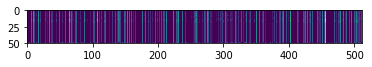

epoch   0 ====pic  10 ===== loss train: 5.6595


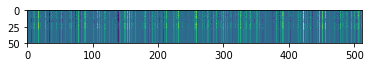

epoch   0 ====pic  20 ===== loss train: 5.9078


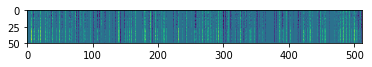

epoch   0 ====pic  30 ===== loss train: 5.2299


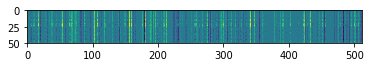

epoch   0 ====pic  40 ===== loss train: 5.0326


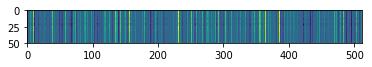

epoch   0 ====pic  50 ===== loss train: 5.5023


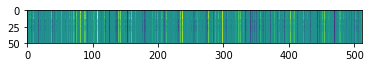

epoch   0 ====pic  60 ===== loss train: 6.2493


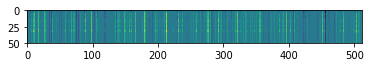

epoch   0 ====pic  70 ===== loss train: 4.5164


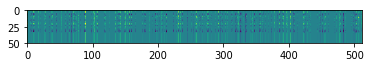

epoch   0 ====pic  80 ===== loss train: 4.8206


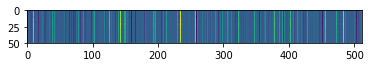

epoch   0 ====pic  90 ===== loss train: 4.0134


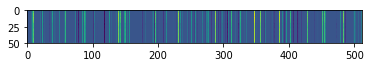

epoch   0 ====pic 100 ===== loss train: 3.6932


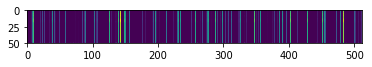

epoch   1 ====pic  10 ===== loss train: 3.9142


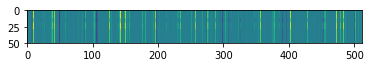

epoch   1 ====pic  20 ===== loss train: 4.8759


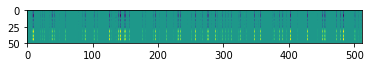

epoch   1 ====pic  30 ===== loss train: 4.5406


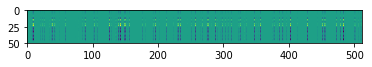

epoch   1 ====pic  40 ===== loss train: 4.5784


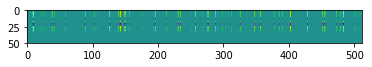

epoch   1 ====pic  50 ===== loss train: 5.6328


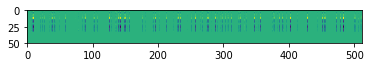

epoch   1 ====pic  60 ===== loss train: 5.6817


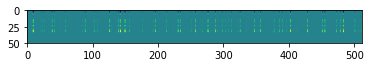

epoch   1 ====pic  70 ===== loss train: 4.0270


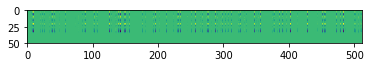

epoch   1 ====pic  80 ===== loss train: 4.4491


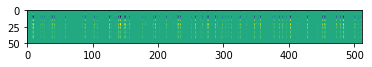

epoch   1 ====pic  90 ===== loss train: 3.5341


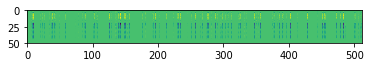

epoch   1 ====pic 100 ===== loss train: 2.5226


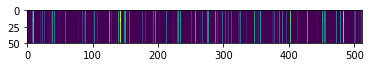

epoch   2 ====pic  10 ===== loss train: 3.1244


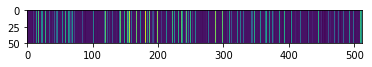

epoch   2 ====pic  20 ===== loss train: 3.7979


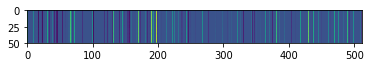

epoch   2 ====pic  30 ===== loss train: 3.8881


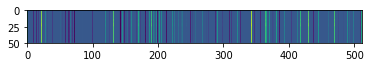

epoch   2 ====pic  40 ===== loss train: 4.9942


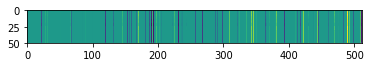

epoch   2 ====pic  50 ===== loss train: 5.0838


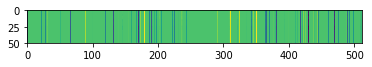

epoch   2 ====pic  60 ===== loss train: 4.4400


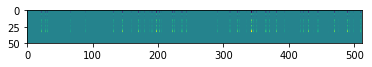

epoch   2 ====pic  70 ===== loss train: 3.3818


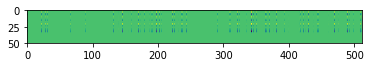

epoch   2 ====pic  80 ===== loss train: 3.7829


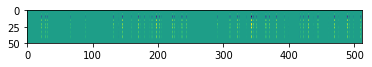

epoch   2 ====pic  90 ===== loss train: 3.2958


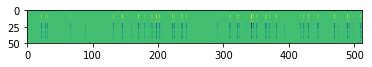

epoch   2 ====pic 100 ===== loss train: 2.0894


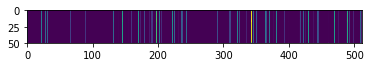

epoch   3 ====pic  10 ===== loss train: 2.7314


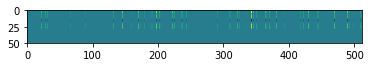

epoch   3 ====pic  20 ===== loss train: 3.2507


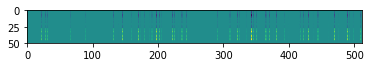

epoch   3 ====pic  30 ===== loss train: 3.7854


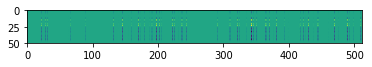

epoch   3 ====pic  40 ===== loss train: 4.2430


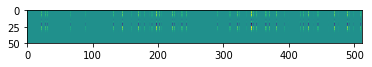

epoch   3 ====pic  50 ===== loss train: 4.5980


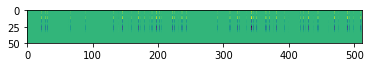

epoch   3 ====pic  60 ===== loss train: 3.6584


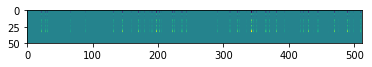

epoch   3 ====pic  70 ===== loss train: 3.1456


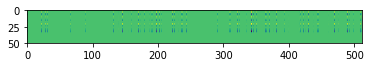

epoch   3 ====pic  80 ===== loss train: 3.2250


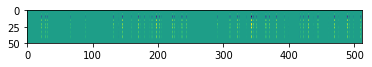

epoch   3 ====pic  90 ===== loss train: 3.0767


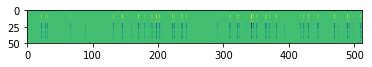

epoch   3 ====pic 100 ===== loss train: 1.9563


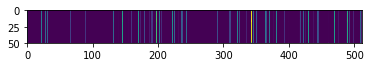

epoch   4 ====pic  10 ===== loss train: 2.7028


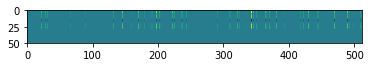

epoch   4 ====pic  20 ===== loss train: 2.6952


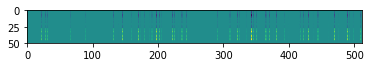

epoch   4 ====pic  30 ===== loss train: 3.3667


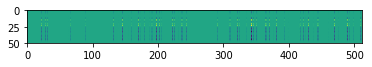

epoch   4 ====pic  40 ===== loss train: 3.7641


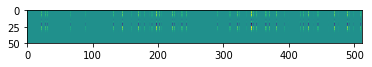

epoch   4 ====pic  50 ===== loss train: 3.9180


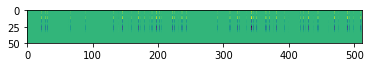

epoch   4 ====pic  60 ===== loss train: 2.9073


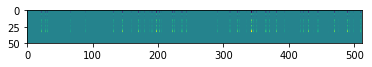

epoch   4 ====pic  70 ===== loss train: 2.7909


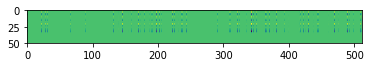

epoch   4 ====pic  80 ===== loss train: 2.7254


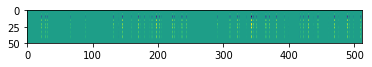

epoch   4 ====pic  90 ===== loss train: 2.9214


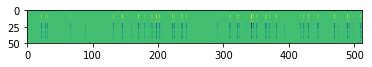

epoch   4 ====pic 100 ===== loss train: 1.5827


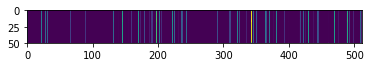

epoch   5 ====pic  10 ===== loss train: 1.9802


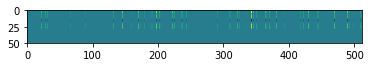

epoch   5 ====pic  20 ===== loss train: 1.8883


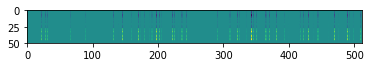

epoch   5 ====pic  30 ===== loss train: 3.0170


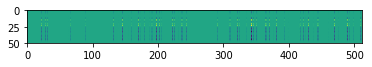

epoch   5 ====pic  40 ===== loss train: 3.5120


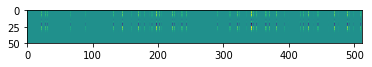

epoch   5 ====pic  50 ===== loss train: 3.4738


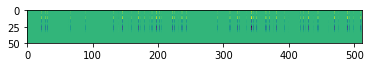

epoch   5 ====pic  60 ===== loss train: 2.0960


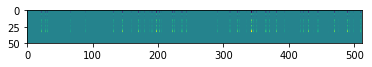

epoch   5 ====pic  70 ===== loss train: 2.5390


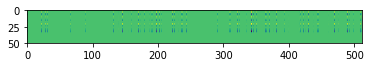

epoch   5 ====pic  80 ===== loss train: 2.0399


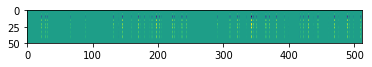

epoch   5 ====pic  90 ===== loss train: 2.8347


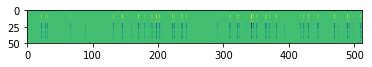

epoch   5 ====pic 100 ===== loss train: 1.2132


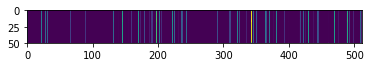

epoch   6 ====pic  10 ===== loss train: 1.5699


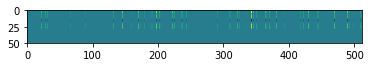

epoch   6 ====pic  20 ===== loss train: 1.4518


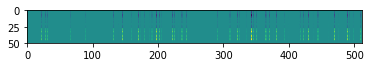

epoch   6 ====pic  30 ===== loss train: 2.6280


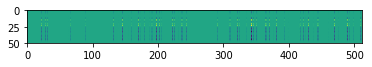

epoch   6 ====pic  40 ===== loss train: 3.0083


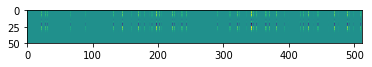

epoch   6 ====pic  50 ===== loss train: 2.5357


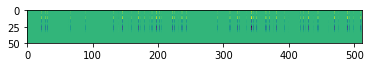

epoch   6 ====pic  60 ===== loss train: 1.5821


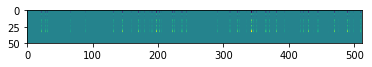

epoch   6 ====pic  70 ===== loss train: 2.2335


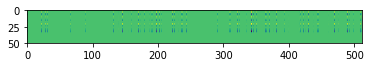

epoch   6 ====pic  80 ===== loss train: 1.6252


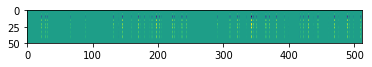

epoch   6 ====pic  90 ===== loss train: 2.4334


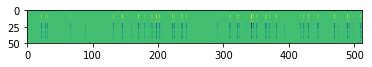

epoch   6 ====pic 100 ===== loss train: 0.9564


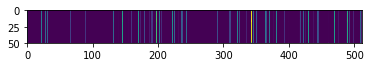

epoch   7 ====pic  10 ===== loss train: 1.1203


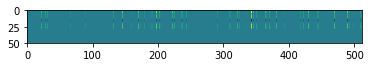

epoch   7 ====pic  20 ===== loss train: 1.0750


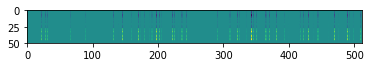

epoch   7 ====pic  30 ===== loss train: 2.0249


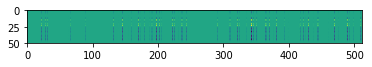

epoch   7 ====pic  40 ===== loss train: 2.3878


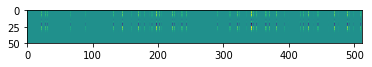

epoch   7 ====pic  50 ===== loss train: 1.7406


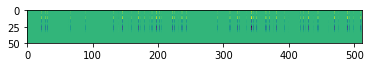

epoch   7 ====pic  60 ===== loss train: 1.0120


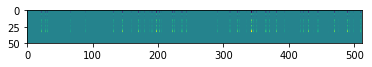

epoch   7 ====pic  70 ===== loss train: 1.8866


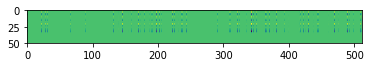

epoch   7 ====pic  80 ===== loss train: 1.3576


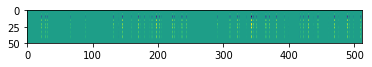

epoch   7 ====pic  90 ===== loss train: 2.0754


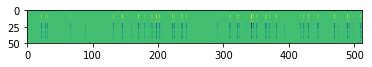

epoch   7 ====pic 100 ===== loss train: 0.7589


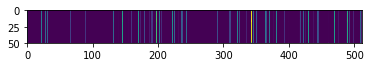

epoch   8 ====pic  10 ===== loss train: 0.7593


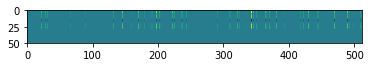

epoch   8 ====pic  20 ===== loss train: 1.0866


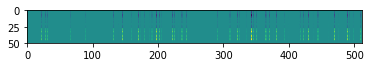

epoch   8 ====pic  30 ===== loss train: 1.5084


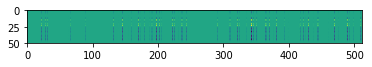

epoch   8 ====pic  40 ===== loss train: 1.9192


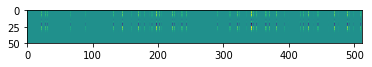

epoch   8 ====pic  50 ===== loss train: 1.2861


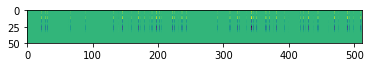

epoch   8 ====pic  60 ===== loss train: 0.9775


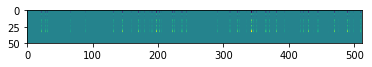

epoch   8 ====pic  70 ===== loss train: 1.5059


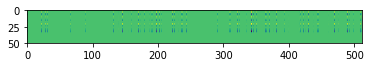

epoch   8 ====pic  80 ===== loss train: 0.8579


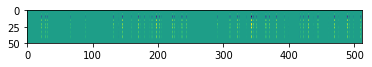

epoch   8 ====pic  90 ===== loss train: 1.7519


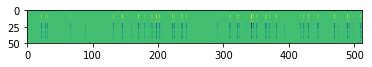

epoch   8 ====pic 100 ===== loss train: 0.3833


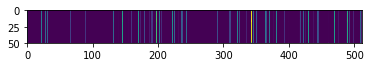

epoch   9 ====pic  10 ===== loss train: 0.4410


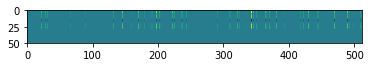

epoch   9 ====pic  20 ===== loss train: 0.7074


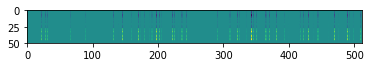

epoch   9 ====pic  30 ===== loss train: 1.0125


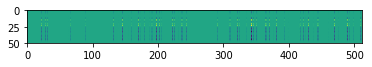

epoch   9 ====pic  40 ===== loss train: 1.3408


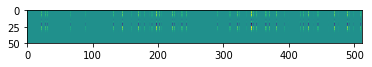

epoch   9 ====pic  50 ===== loss train: 0.8026


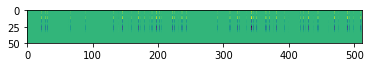

epoch   9 ====pic  60 ===== loss train: 0.6763


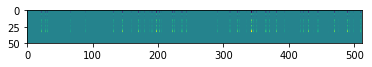

epoch   9 ====pic  70 ===== loss train: 1.1482


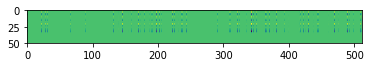

epoch   9 ====pic  80 ===== loss train: 0.5243


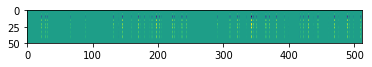

epoch   9 ====pic  90 ===== loss train: 1.3901


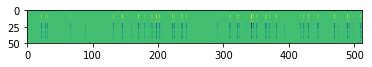

epoch   9 ====pic 100 ===== loss train: 0.3869


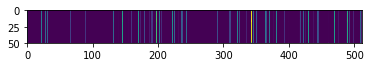

epoch  10 ====pic  10 ===== loss train: 0.5261


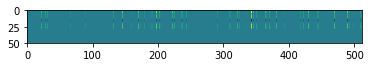

epoch  10 ====pic  20 ===== loss train: 0.6821


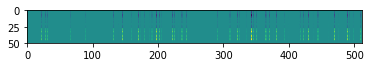

epoch  10 ====pic  30 ===== loss train: 0.7042


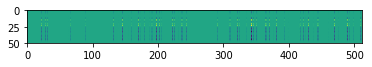

epoch  10 ====pic  40 ===== loss train: 1.0373


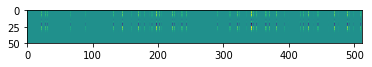

epoch  10 ====pic  50 ===== loss train: 0.4916


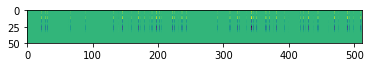

epoch  10 ====pic  60 ===== loss train: 0.5865


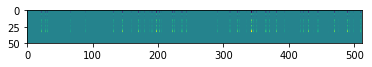

epoch  10 ====pic  70 ===== loss train: 0.8871


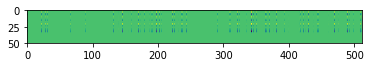

epoch  10 ====pic  80 ===== loss train: 0.4061


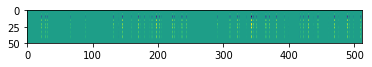

epoch  10 ====pic  90 ===== loss train: 1.0591


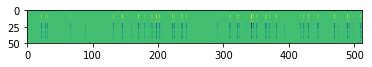

epoch  10 ====pic 100 ===== loss train: 0.3151


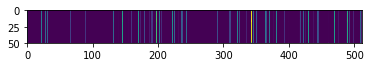

epoch  11 ====pic  10 ===== loss train: 0.3673


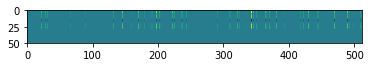

epoch  11 ====pic  20 ===== loss train: 0.5753


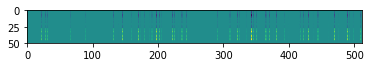

epoch  11 ====pic  30 ===== loss train: 0.7009


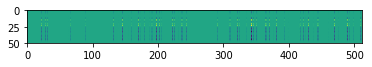

epoch  11 ====pic  40 ===== loss train: 0.7043


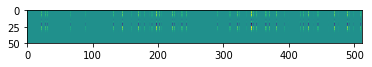

epoch  11 ====pic  50 ===== loss train: 0.4159


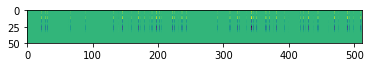

epoch  11 ====pic  60 ===== loss train: 0.6288


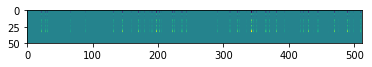

epoch  11 ====pic  70 ===== loss train: 0.4763


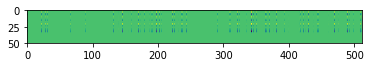

epoch  11 ====pic  80 ===== loss train: 0.3517


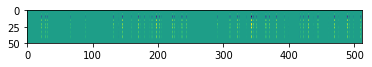

epoch  11 ====pic  90 ===== loss train: 0.7068


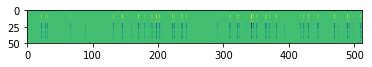

epoch  11 ====pic 100 ===== loss train: 0.1835


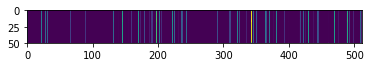

epoch  12 ====pic  10 ===== loss train: 0.2772


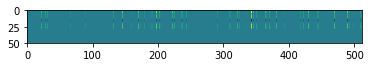

epoch  12 ====pic  20 ===== loss train: 0.3010


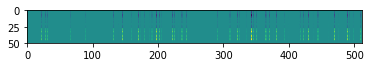

epoch  12 ====pic  30 ===== loss train: 0.3748


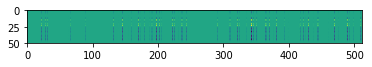

epoch  12 ====pic  40 ===== loss train: 0.5057


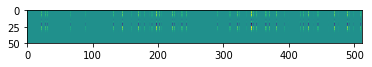

epoch  12 ====pic  50 ===== loss train: 0.2980


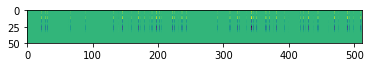

epoch  12 ====pic  60 ===== loss train: 0.8649


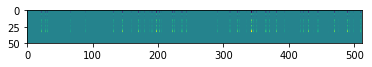

epoch  12 ====pic  70 ===== loss train: 0.3056


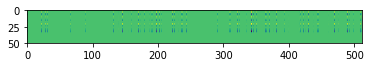

epoch  12 ====pic  80 ===== loss train: 0.6257


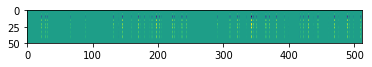

epoch  12 ====pic  90 ===== loss train: 0.4755


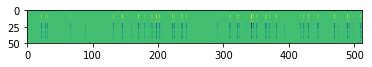

epoch  12 ====pic 100 ===== loss train: 0.1557


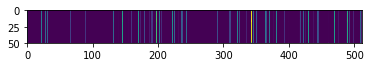

epoch  13 ====pic  10 ===== loss train: 0.2413


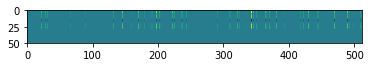

epoch  13 ====pic  20 ===== loss train: 0.5361


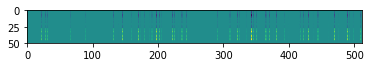

epoch  13 ====pic  30 ===== loss train: 0.3391


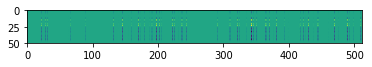

epoch  13 ====pic  40 ===== loss train: 0.3770


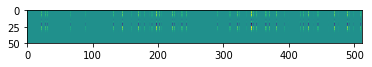

epoch  13 ====pic  50 ===== loss train: 0.2499


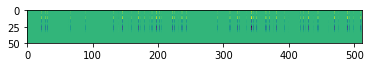

epoch  13 ====pic  60 ===== loss train: 0.6885


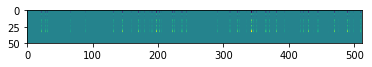

epoch  13 ====pic  70 ===== loss train: 0.2176


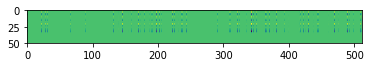

epoch  13 ====pic  80 ===== loss train: 0.7250


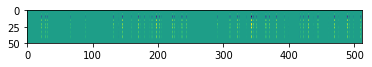

epoch  13 ====pic  90 ===== loss train: 0.4313


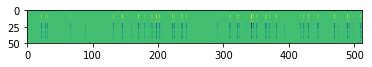

epoch  13 ====pic 100 ===== loss train: 0.2438


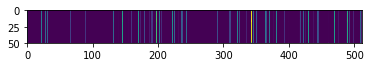

epoch  14 ====pic  10 ===== loss train: 0.2904


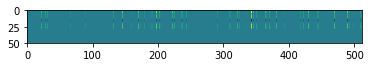

epoch  14 ====pic  20 ===== loss train: 0.2773


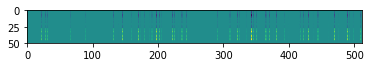

epoch  14 ====pic  30 ===== loss train: 0.3324


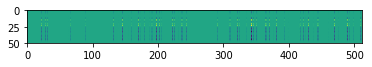

epoch  14 ====pic  40 ===== loss train: 0.2981


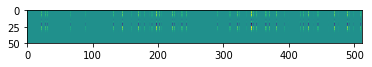

epoch  14 ====pic  50 ===== loss train: 0.2885


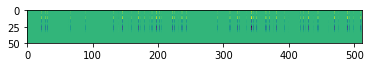

epoch  14 ====pic  60 ===== loss train: 0.7817


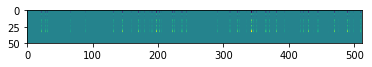

epoch  14 ====pic  70 ===== loss train: 0.1837


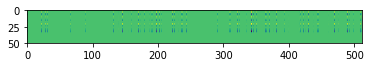

epoch  14 ====pic  80 ===== loss train: 0.2651


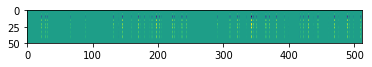

epoch  14 ====pic  90 ===== loss train: 0.2259


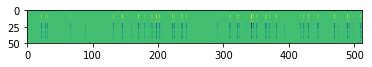

epoch  14 ====pic 100 ===== loss train: 0.1327


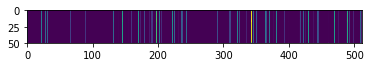

epoch  15 ====pic  10 ===== loss train: 0.2899


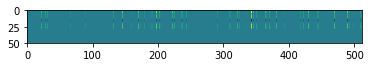

epoch  15 ====pic  20 ===== loss train: 0.5592


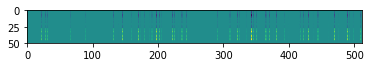

epoch  15 ====pic  30 ===== loss train: 0.2452


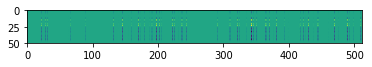

epoch  15 ====pic  40 ===== loss train: 0.2287


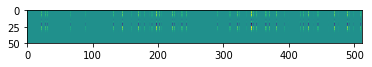

epoch  15 ====pic  50 ===== loss train: 0.2760


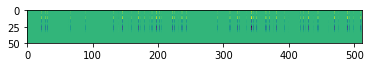

epoch  15 ====pic  60 ===== loss train: 0.5846


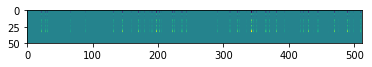

epoch  15 ====pic  70 ===== loss train: 0.3056


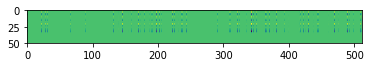

epoch  15 ====pic  80 ===== loss train: 0.2882


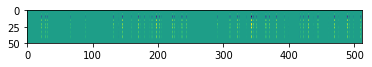

epoch  15 ====pic  90 ===== loss train: 0.2304


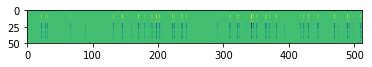

epoch  15 ====pic 100 ===== loss train: 0.1435


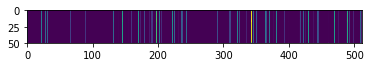

epoch  16 ====pic  10 ===== loss train: 0.2345


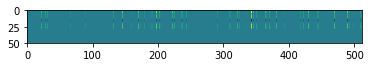

epoch  16 ====pic  20 ===== loss train: 0.2318


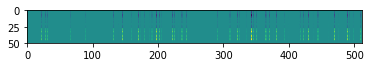

epoch  16 ====pic  30 ===== loss train: 0.2141


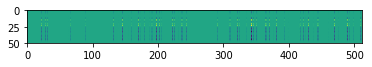

epoch  16 ====pic  40 ===== loss train: 0.2079


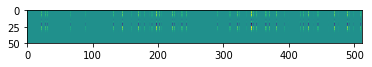

epoch  16 ====pic  50 ===== loss train: 0.2666


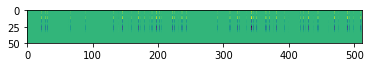

epoch  16 ====pic  60 ===== loss train: 0.4453


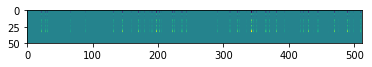

epoch  16 ====pic  70 ===== loss train: 0.1876


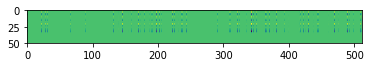

epoch  16 ====pic  80 ===== loss train: 0.1976


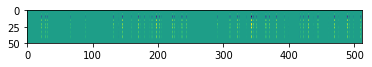

epoch  16 ====pic  90 ===== loss train: 0.1658


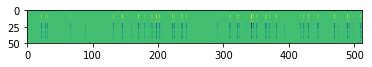

epoch  16 ====pic 100 ===== loss train: 0.1479


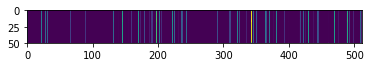

epoch  17 ====pic  10 ===== loss train: 0.2230


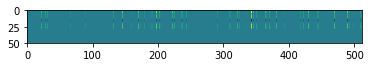

epoch  17 ====pic  20 ===== loss train: 0.3655


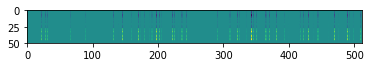

epoch  17 ====pic  30 ===== loss train: 0.1799


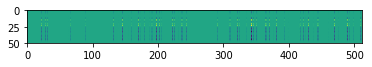

epoch  17 ====pic  40 ===== loss train: 0.1586


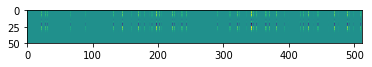

epoch  17 ====pic  50 ===== loss train: 0.2772


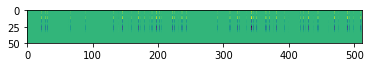

epoch  17 ====pic  60 ===== loss train: 0.4242


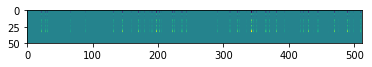

epoch  17 ====pic  70 ===== loss train: 0.2123


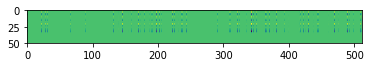

epoch  17 ====pic  80 ===== loss train: 0.2674


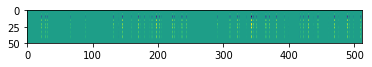

epoch  17 ====pic  90 ===== loss train: 0.1628


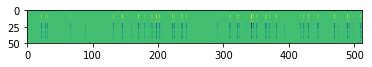

epoch  17 ====pic 100 ===== loss train: 0.1311


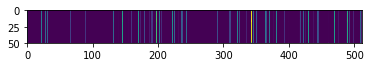

epoch  18 ====pic  10 ===== loss train: 0.2322


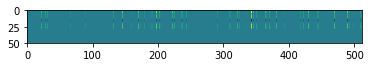

epoch  18 ====pic  20 ===== loss train: 0.1938


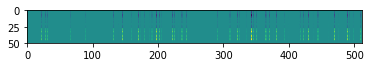

epoch  18 ====pic  30 ===== loss train: 0.1925


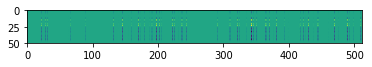

epoch  18 ====pic  40 ===== loss train: 0.1412


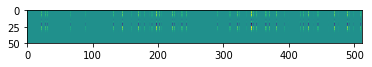

epoch  18 ====pic  50 ===== loss train: 0.2639


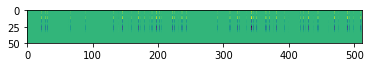

epoch  18 ====pic  60 ===== loss train: 0.4700


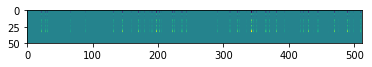

epoch  18 ====pic  70 ===== loss train: 0.1355


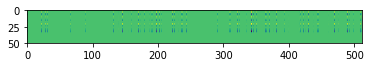

epoch  18 ====pic  80 ===== loss train: 0.4052


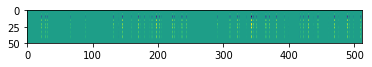

epoch  18 ====pic  90 ===== loss train: 0.1201


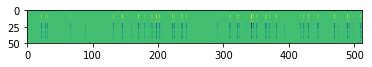

epoch  18 ====pic 100 ===== loss train: 0.1152


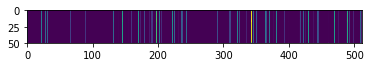

epoch  19 ====pic  10 ===== loss train: 0.2318


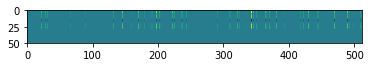

epoch  19 ====pic  20 ===== loss train: 0.1688


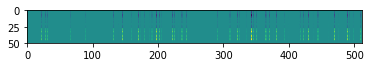

epoch  19 ====pic  30 ===== loss train: 0.1904


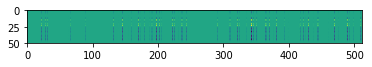

epoch  19 ====pic  40 ===== loss train: 0.1236


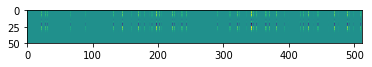

epoch  19 ====pic  50 ===== loss train: 0.2532


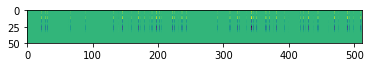

epoch  19 ====pic  60 ===== loss train: 0.5756


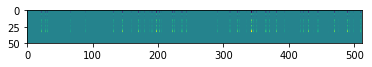

epoch  19 ====pic  70 ===== loss train: 0.1733


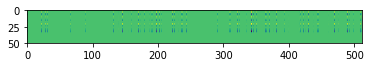

epoch  19 ====pic  80 ===== loss train: 0.2566


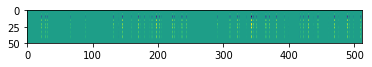

epoch  19 ====pic  90 ===== loss train: 0.1134


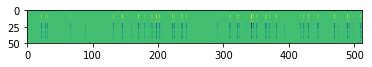

epoch  19 ====pic 100 ===== loss train: 0.2010


In [23]:
import numpy as np

lr_base = 2e-3


session = tf.Session()


session.run(tf.global_variables_initializer())


for epoch in range(epochs):
    
    train, _ = load_data()
    
    i = 0
    
    if epoch>0:
        
        lr_base = lr_base * lr_decay
        
    W0 = np.zeros((50, 512))
    for datum1 in train:
        
        
        
        if i == 100 :
            break
        
        i += 1

        inp = datum1[0]
        seq = np.asarray(datum1[1])

        seq = np.array(seq)
        seq = np.reshape(seq,(1,len(seq)))
        # seq = np.roll(seq,-1,axis=1)

        inp = np.reshape(inp,(1,60,400,1))

        feed_dict = {
            Input: inp,
            time_steps: seq.shape[1],
            Decoder_Input: seq[:,0:-1],
            tf_lr:lr_base,
            Decoder_Target: seq[:,1:]
        }
        
        loss_train, _,W = session.run([loss,train_opt,CONV5], feed_dict = feed_dict)
        
        conv_w = W[0,0,:,:]
        

        
        if i % 10 == 0 :
            plt.imshow(conv_w-W0, interpolation='nearest')
            plt.show()
            W0 = conv_w
            print("epoch %3i"%epoch,"====pic %3i"%i,"===== loss train: %.4f"%loss_train)
             
#             idx = random.randint(0,7390)
            
#             j = 0
            
#             for datum2 in val:
                
#                 j+=1
#                 if j == idx:
                
#                     inp = datum2[0]
#                     seq = np.asarray(datum2[1])

#                     seq = np.array(seq)
#                     seq = np.reshape(seq,(1,len(seq)))
#                     seq = np.roll(seq,-1,axis=1)

#                     inp = np.reshape(inp,(1,60,400,1))

#                     feed_dict = {
#                         Input: inp,
#                         time_steps: seq.shape[1],
#                         Decoder_Input: seq,
#                         Decoder_Target: seq[:, 1:]
#                     }

#                     loss_valid = session.run(loss, feed_dict = feed_dict)
                
                    
                    
saver = tf.train.Saver()
path = 'save_models'
# os.mkdir(path)
save_path = saver.save(session,path+'/model')


In [ ]:
#for datum in test:
num_t = 160


j = 0

f1name = 'target.txt'
f1 = open(f1name,'w')

f2name = 'predicted.txt'
f2 = open(f2name,'w')



train, _ = load_data()
for datum1 in train:
    
    if j == 3:
        break
    
    j += 1

    
    ####################################
    inp = datum1[0]
    inp = np.reshape(inp,(1,60,400,1))
    
    seq2 = np.asarray(datum1[1])
    seq2 = np.reshape(seq2,(1,len(seq2)))
    ####################################
    
    i = 0
    seq = np.zeros((1,num_t))

    while (i < num_t-1):

        i += 1
        
        feed_dict = {
            Input: inp,
            time_steps : num_t,
            Decoder_Input : seq
            }

        all_logit = session.run(all_logits, feed_dict = feed_dict)



        seq[0,i] = np.argmax(all_logit[i-1,:])

        if np.argmax(all_logit[i-1,:]) == 1:
            break
    

    for k in range(1,num_t):
        if seq[0][k] == 0:
            my_ans = seq[0][0:k]
            break
                
    for ww in range(len(my_ans)):
        
        if my_ans[ww] == 2:
            my_ans[ww] == 10

    ans = my_ans[1:-1]-3
    real_ans = seq2[0][1:-1]-3

    
    #print(real_ans)
    
    t1 = [' '.join([idx_to_vocab[q] for q in ans])]
    t2 = [' '.join([idx_to_vocab[x] for x in real_ans])]
    print(t1)
    print(t2)
    
    exp1 = t1[0]+'\n'
    exp2 = t2[0]+'\n'
    
    f1.write(exp1)
    f2.write(exp2)
    
f1.close()
f2.close()   

In [25]:
cmd =  "gnome-terminal -e 'python3 Evaluation/bleu_score.py --target-formulas target.txt --predicted-formulas predicted.txt --ngram 5'"
process = subprocess.Popen(shlex.split(cmd), stdout=subprocess.PIPE)